# Round One - EDA and Research
    This file contains a research of possible indicators for a profitable strat

#### 1. Extracting Data

In [15]:
from Utils import ziputils
ROUND = 1
ziputils.unzip(ROUND)

In [16]:
from Utils import Config, ziputils, dataUtils
from Utils.Algos import algo_mesoplodon_bowdoini
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Ramon\AppData\Local\Temp\ipykernel_1844\653547427.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["variance"] = (df["mid_price"].rolling(window).std()) ** 2
C:\Users\Ramon\AppData\Local\Temp\ipykernel_1844\653547427.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns"] = df["mid_price"].pct_change(window)
C:\Users\Ramon\AppData\Local\Temp\ipykernel_1844\653547427.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

300
300


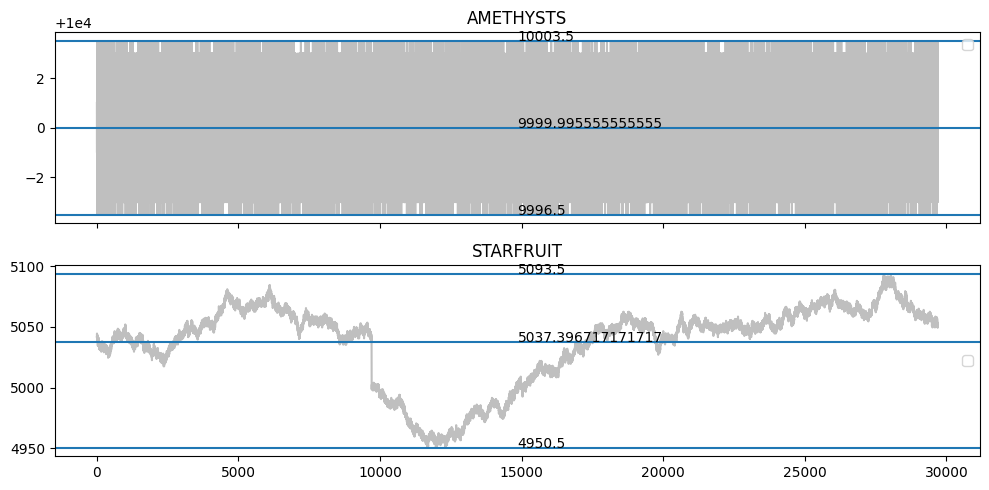

In [17]:
data = dataUtils.getDataPaths(1)

class MarketData:
    prices_df = dataUtils.concat_dfs("prices", data)
    trades_df = dataUtils.concat_dfs("trades", data)
    Products = list(prices_df["product"].unique())

    def construct_dfs():
        dfs_prices = {}
        for product in MarketData.Products:
            dfs_prices[product] = MarketData.prices_df[MarketData.prices_df["product"] == product]
        return dfs_prices
    
    def visualize_products(dfs):
        rows = len(dfs)
        fig, axs = plt.subplots(rows, sharex=True, figsize=(10, 5))
        for ax, (product_name, df) in enumerate(dfs.items()):
            bid = df.bid_price_1
            ask = df.ask_price_1
            x = len(df)/2
            axs[ax].plot(df.mid_price, color="grey", alpha=0.50)
            axs[ax].axhline(m:=np.mean(df.mid_price))
            axs[ax].annotate(str(np.mean(df.mid_price)), xy=(x,m))
            axs[ax].axhline(m:=np.max(df.mid_price))
            axs[ax].annotate(str(np.max(df.mid_price)), xy=(x,m))
            axs[ax].axhline(m:=np.min(df.mid_price))
            axs[ax].annotate(str(np.min(df.mid_price)), xy=(x,m))
            axs[ax].set_title(product_name)
            axs[ax].legend()
        plt.tight_layout()
        plt.show()

    def describe_price(dfs):
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_axes([0, 0, 1, 1])
        price_vec = []
        for prod,df in dfs.items():
            price = df.mid_price
            price_vec.append((np.min(price),np.max(price), np.mean(price)))
        plt.hist(price_vec)
        #plt.annotate(f"Max : {np.max(df.mid_price)}",xy=(np.max(df.mid_price)))

    def buildFeatures(df):
        window = int(len(df) * 0.01)
        print(window)
        df["variance"] = (df["mid_price"].rolling(window).std()) ** 2
        df["returns"] = df["mid_price"].pct_change(window)
        df["predictions"] = df["mid_price"]
        df.bfill(inplace=True)
        MarketData.O_Book_Imbalance(df)
        df["RSI"]
        df.drop(df.index[0:window], inplace = True)
        df.fillna(0,inplace=True)

    def constructFeatures(dfs):
        for product in MarketData.Products:
            MarketData.buildFeatures(df:=dfs[product])
            df.reset_index(inplace=True)

    def visualize_feats(df, features):
        n_features = len(features)
        fig, axs = plt.subplots(n_features, figsize=(10, n_features*2),sharex=True)
        for i, feature in enumerate(features):
            if "volume" in feature:
                axs[i].plot(df[feature], color = "c")
            else:
                axs[i].plot(df[feature], color = "c")
            axs[i].set_title(feature)
   
    def feature_corr(df, main_feats):
        fig = plt.figure(figsize=(5, 7))
        sns.heatmap(df[main_feats].corr())

    def O_Book_Imbalance(df):
        #can only be used when fillna is previously called on the df
        df["OBI"] = ((df["bid_volume_1"]+df["bid_volume_3"]+df["bid_volume_2"]) - (df["ask_volume_1"]+df["ask_volume_3"]+df["ask_volume_2"])) / ((df["bid_volume_1"]+df["bid_volume_3"]+df["bid_volume_2"]) + (df["ask_volume_1"]+df["ask_volume_3"]+df["ask_volume_2"]))

dfs = MarketData.construct_dfs()
MarketData.constructFeatures(dfs)
MarketData.visualize_products(dfs)

#### Explore Features

- AMETHYSTS

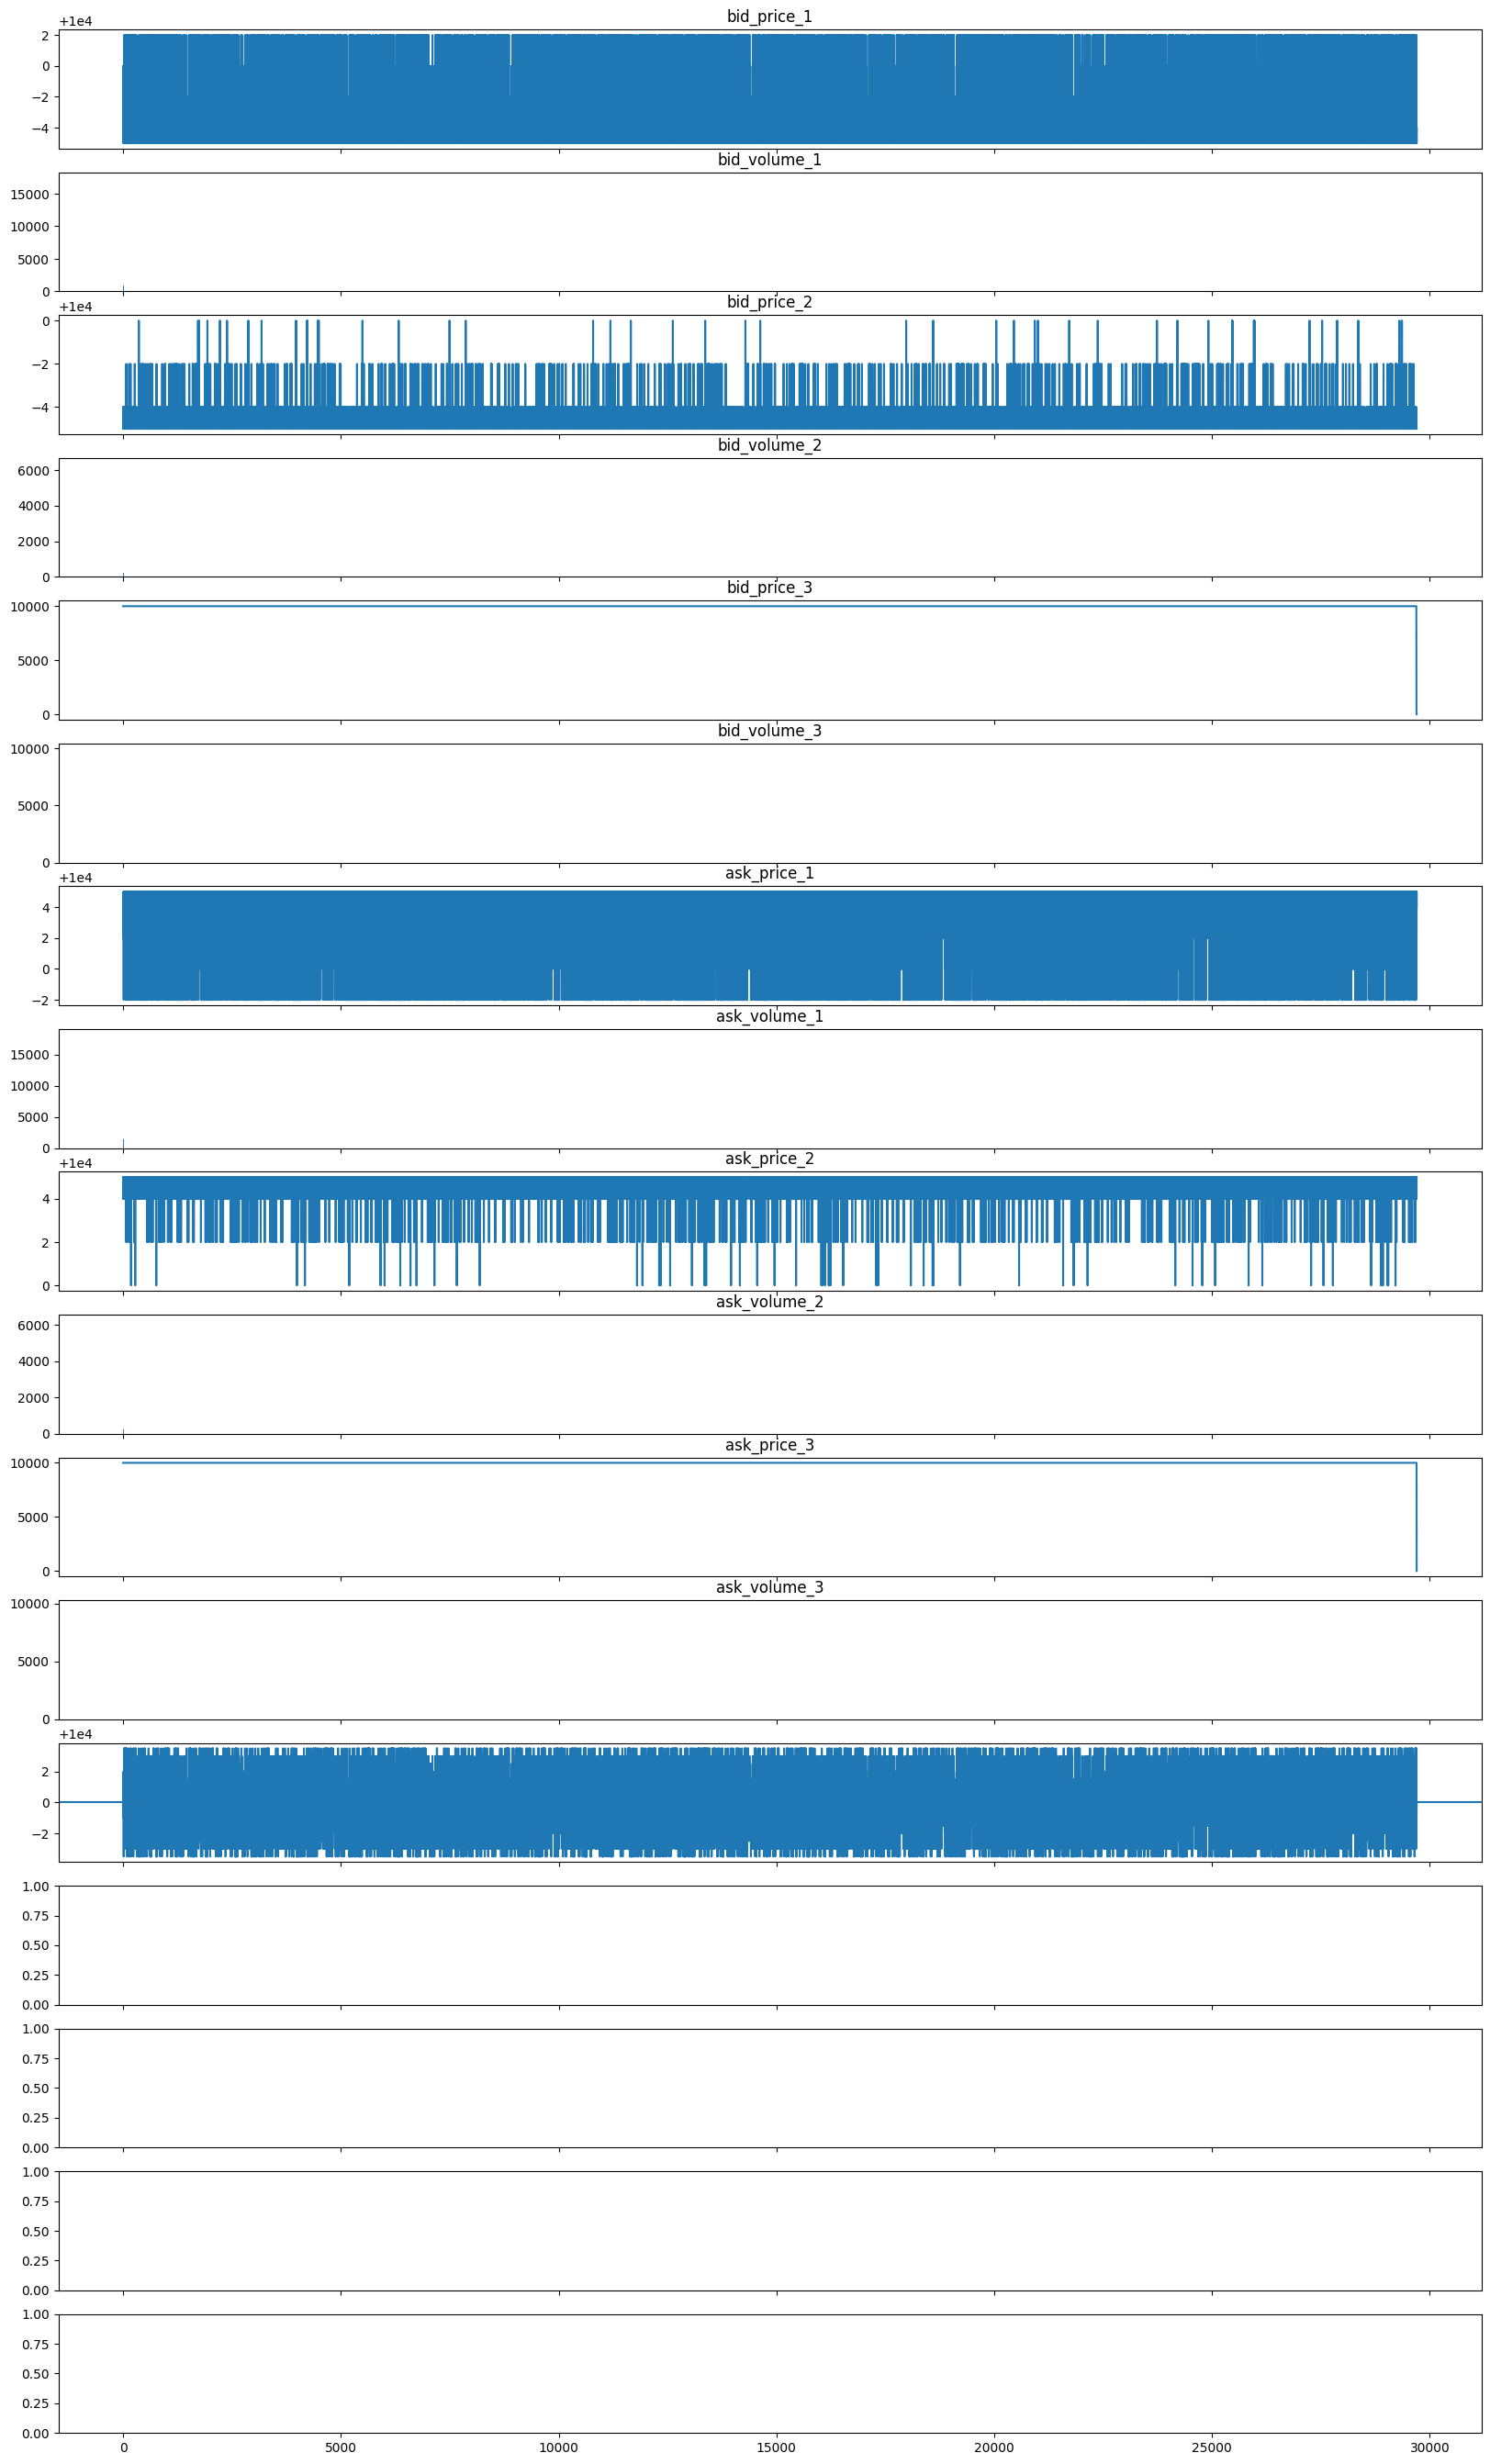

In [18]:
amethysts = dfs["AMETHYSTS"]
amethysts.to_csv(f"{Config.DATA_DIR}/round_{ROUND}/amethysts.csv")
exclude_feats = ["index", "day", "timestamp", "product", "profit_and_loss"]
features = [i for i in amethysts.columns if i not in exclude_feats]
n_features = len(features)

fig, axs = plt.subplots(n_features, figsize=(20, n_features*2),sharex=True)
for i, feature in enumerate(features):
    if "mid_price" in feature:
        axs[i].plot(amethysts[feature])
        axs[i].axhline(m:=np.mean(amethysts.mid_price))
        break
    if "volume" in feature:
        axs[i].hist(amethysts[feature])
    else:
        axs[i].plot(amethysts[feature])
    axs[i].set_title(feature)

- STARFRUIT

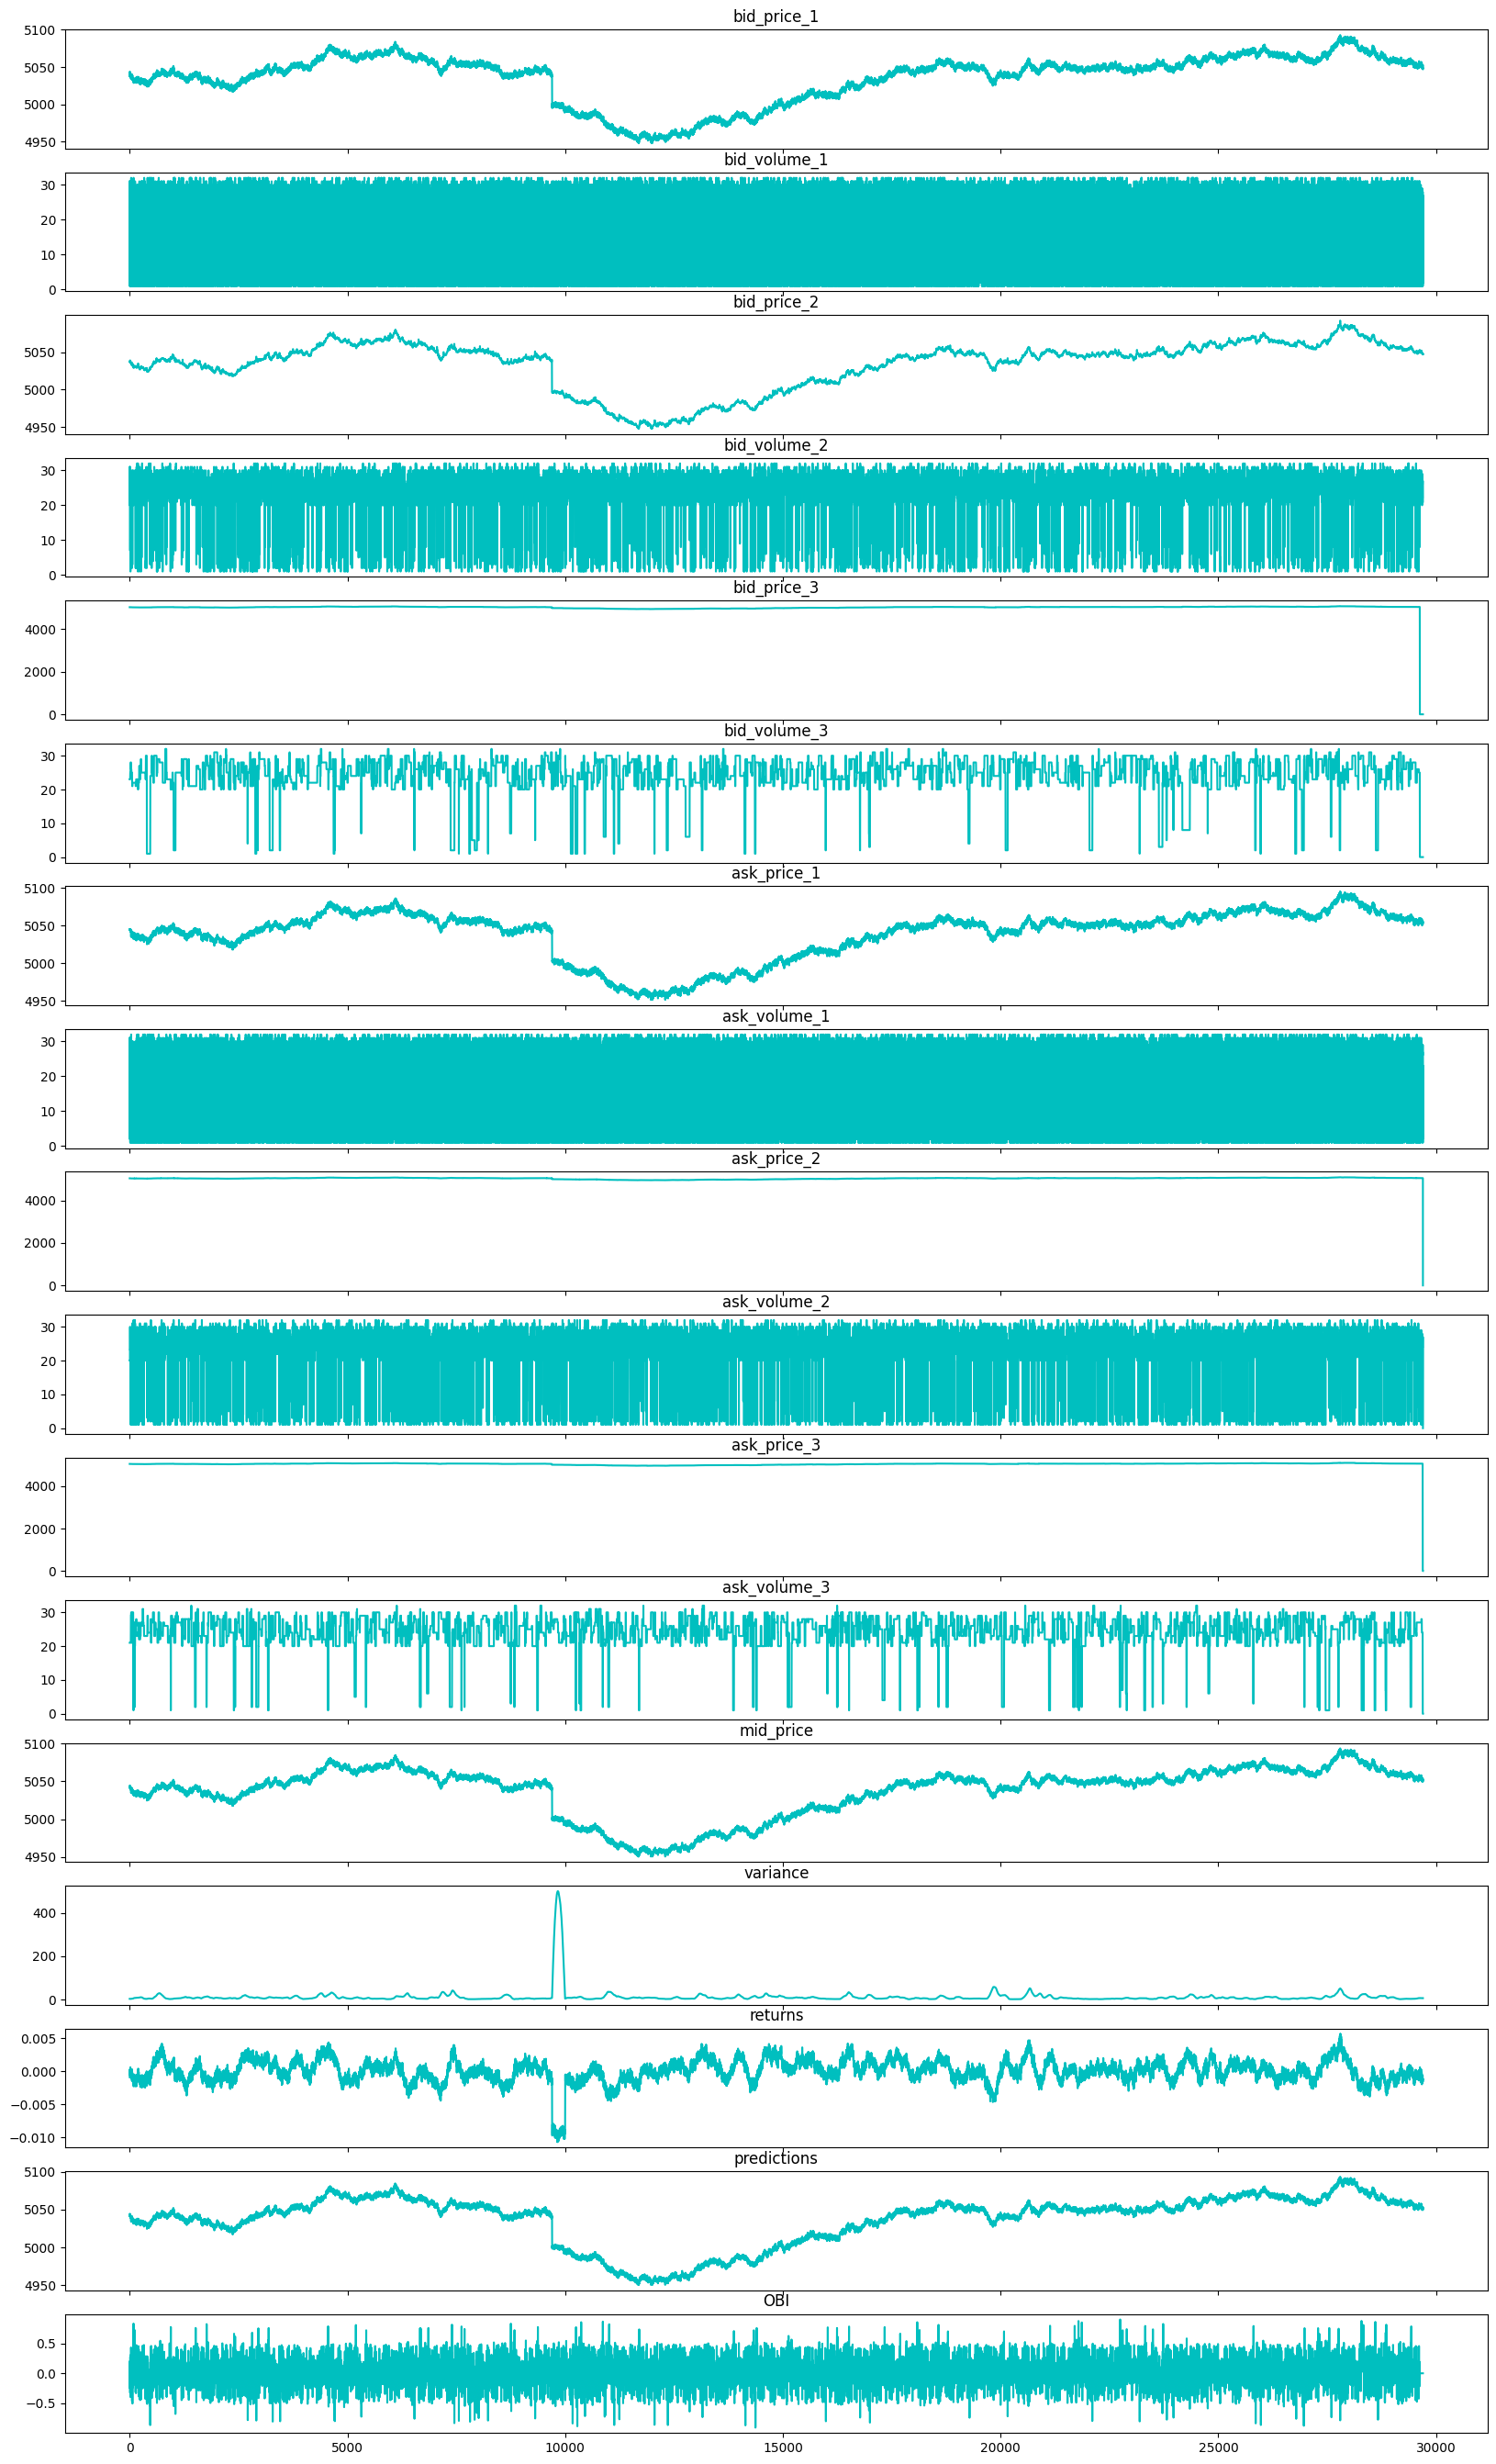

In [19]:
starfruit = dfs["STARFRUIT"]
starfruit.to_csv(f"{Config.DATA_DIR}/round_{ROUND}/starfruit.csv")
main_feats = [i for i in starfruit.columns if i not in exclude_feats]
n_features = len(features)

fig, axs = plt.subplots(n_features, figsize=(20, n_features*2),sharex=True)
for i, feature in enumerate(features):
    if "volume" in feature:
        axs[i].plot(starfruit[feature], color = "c")
    else:
        axs[i].plot(starfruit[feature], color = "c")
    axs[i].set_title(feature)



> Comment : for a mean reverting strategy only some bid ask levels add information without noise. Therefore we will avoid using depth level 1 and limit level 2 to avoid adding noise to our system. Now we will search for key movements in volatility to see what happened at level 3 and 2 before significant price movements. The idea is to add some measure of volatility where to trade.

In [20]:
starfruit

,index,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,...,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,variance,returns,predictions,OBI
0,600,-1,30000,STARFRUIT,5038,31,5037.0,28.0,5038.0,23.0,...,5045.0,20.0,5044.0,21.0,5041.5,0.0,4.056979,-0.000892,5041.5,0.064935
1,603,-1,30100,STARFRUIT,5038,2,5037.0,28.0,5038.0,23.0,...,5045.0,20.0,5044.0,21.0,5041.0,0.0,4.033880,-0.000397,5041.0,-0.145161
2,604,-1,30200,STARFRUIT,5038,2,5037.0,20.0,5038.0,23.0,...,5045.0,20.0,5044.0,21.0,5041.0,0.0,3.989030,-0.000595,5041.0,-0.166667
3,606,-1,30300,STARFRUIT,5044,1,5038.0,31.0,5038.0,23.0,...,5045.0,20.0,5044.0,21.0,5044.5,0.0,4.024022,0.000297,5044.5,-0.133858
4,608,-1,30400,STARFRUIT,5041,5,5038.0,31.0,5038.0,23.0,...,5045.0,20.0,5044.0,21.0,5043.0,0.0,4.032330,0.000099,5043.0,-0.099237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29695,59990,0,999500,STARFRUIT,5049,28,5047.0,27.0,0.0,0.0,...,5055.0,24.0,0.0,0.0,5052.5,0.0,7.147322,-0.001087,5052.5,0.000000
29696,59992,0,999600,STARFRUIT,5048,9,5047.0,27.0,0.0,0.0,...,5055.0,24.0,0.0,0.0,5051.0,0.0,7.152940,-0.001581,5051.0,0.000000
29697,59995,0,999700,STARFRUIT,5053,1,5048.0,26.0,0.0,0.0,...,5055.0,24.0,0.0,0.0,5053.5,0.0,7.063041,-0.001383,5053.5,0.000000
29698,59996,0,999800,STARFRUIT,5047,27,5047.0,21.0,0.0,0.0,...,5054.0,27.0,0.0,0.0,5049.5,0.0,7.146251,-0.001582,5049.5,0.000000


In [63]:

main_feats = [i for i in starfruit.columns if (("OBI" in i) or ("predictions" in i) or ("_3" in i and i not in exclude_feats) or (("variance" in i) or ("returns" in i) or ("mid_price" in i)))]
noise_feats = [i for i in starfruit.columns if (i not in main_feats and i not in exclude_feats)]
df_sf = starfruit[main_feats]
df_am = amethysts[main_feats]
df_sf["predictions"] = df_sf["mid_price"]
df_am["predictions"] = df_am["mid_price"]

print(main_feats)

['bid_price_3', 'bid_volume_3', 'ask_price_3', 'ask_volume_3', 'mid_price', 'variance', 'returns', 'predictions', 'OBI']


C:\Users\Ramon\AppData\Local\Temp\ipykernel_1844\1484691167.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sf["predictions"] = df_sf["mid_price"]
C:\Users\Ramon\AppData\Local\Temp\ipykernel_1844\1484691167.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_am["predictions"] = df_am["mid_price"]


#### Approximate function of returns with level 3 data

In [77]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [78]:
cutoff = 0.80
y = "mid_price"
p = "predictions"
r = "returns"
X = [i for i in main_feats if (i not in [r,p,y])]
print(X)

ts_df_sf = df_sf.shift(1)
ts_df_sf.dropna(inplace=True)
ts_df_am = df_am.shift(1)
ts_df_sf.dropna(inplace=True)


print(main_feats)
print(df_sf.columns)

train_sf = pd.DataFrame(ts_df_sf[:int(len(ts_df_sf)*cutoff)], columns=main_feats)
test_sf = pd.DataFrame(ts_df_sf[int(len(ts_df_sf)*cutoff):], columns=main_feats)
sf_y_train = train_sf[y]
sf_X_train = train_sf[X]
sf_y_test = test_sf[y]
sf_X_test = test_sf[X]

train_am = pd.DataFrame(ts_df_am[:int(len(ts_df_am)*cutoff)], columns=main_feats)
test_am = pd.DataFrame(ts_df_am[int(len(ts_df_am)*cutoff):], columns=main_feats)
am_y_train = train_am[y]
am_X_train = train_am[X]
am_y_test = test_am[y]
am_X_test = test_am[X]


['bid_price_3', 'bid_volume_3', 'ask_price_3', 'ask_volume_3', 'variance', 'OBI']
['bid_price_3', 'bid_volume_3', 'ask_price_3', 'ask_volume_3', 'mid_price', 'variance', 'returns', 'predictions', 'OBI']
Index(['bid_price_3', 'bid_volume_3', 'ask_price_3', 'ask_volume_3',
       'mid_price', 'variance', 'returns', 'predictions', 'OBI'],
      dtype='object')


[ 5.2630e-01  5.5900e-02  4.7100e-01 -5.6000e-02  2.0000e-04 -4.2105e+00]


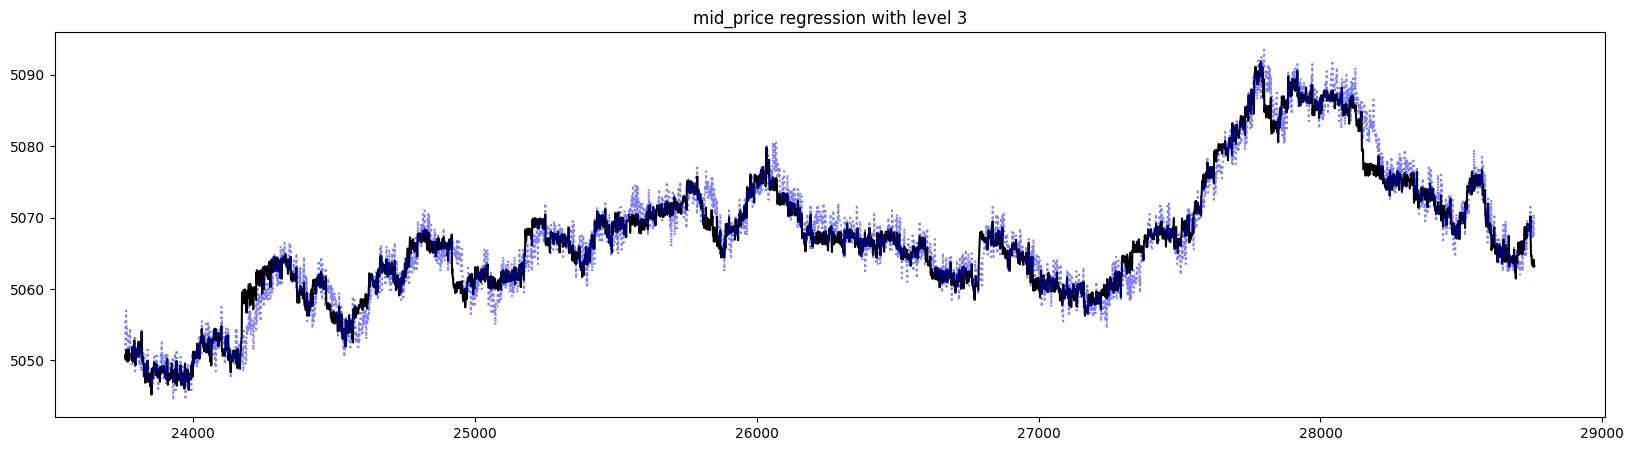

In [79]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=1,fit_intercept=True)
model.fit(sf_X_train, sf_y_train)

sf_y_pred = model.predict(sf_X_test)
test_sf["predictions"] = sf_y_pred
inverse_sf = pd.DataFrame(test_sf, columns=test_sf.columns)[0:5000]
inverse_sf_preds = inverse_sf["predictions"]
real_mid_price = inverse_sf["mid_price"]
model_coefs = np.round(model.coef_, 4)

fig = plt.figure(figsize=(20,5))
plt.plot(inverse_sf_preds, color="black")
plt.plot(real_mid_price, color="blue", linestyle="dotted", alpha=0.50)
#plt.annotate(str(f"{model_coefs[0]} * {X[0]} {model_coefs[1]} * {X[1]} {model_coefs[2]} * {X[2]}"), xy=(len(real_mid_price)/2,real_mid_price.max()))
plt.title("mid_price regression with level 3")
plt.savefig(f"{Config.CHARTS_DIR}/SF_predict_mid_price_R1.jpg")
print(model_coefs)
# print(
#     f"MSE = {mean_squared_error(inverse_sf_preds, real_mid_price)}\n",
#     f"""
#     MID_PRICE (y) = 
#     {model_coefs[0]} * {X[0]}
#     {model_coefs[1]} * {X[1]}
#     {model_coefs[2]} * {X[2]}
#     {model_coefs[3]} * {X[3]}
#     {model_coefs[4]} * {X[4]}
#     {model_coefs[5]} * {X[5]}
#     """
# )

2. Search for optimum portfolio

In [25]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

,AMETHYSTS,STARFRUIT
0,0.00000,0.000000
1,-0.00010,-0.000099
2,0.00000,0.000000
3,-0.00010,0.000694
4,0.00020,-0.000297
...,...,...
29695,-0.00015,0.000198
29696,0.00005,-0.000297
29697,0.00010,0.000495
29698,0.00000,-0.000792


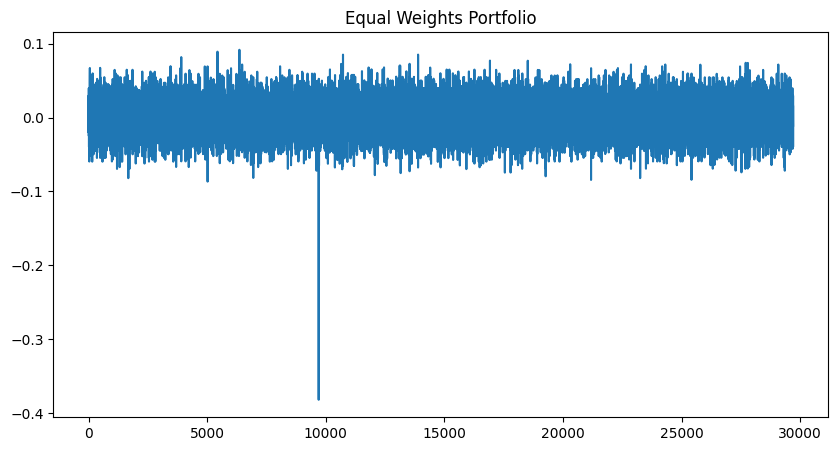

In [26]:
assets = ["AMETHYSTS", "STARFRUIT"]
equal_weights = np.array([100/len(assets) for i in assets])
portfolio = pd.DataFrame(zip(amethysts.mid_price, starfruit.mid_price),columns=assets,index=range(l:=len(amethysts.returns)))
portfolio.bfill(inplace=True)
returns = portfolio.pct_change()
returns.fillna(0,inplace=True)
covariance = returns.cov()

portfolio_variance = np.dot(equal_weights.T, np.dot(covariance, equal_weights))
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_return = np.sum(returns.mean()*equal_weights) * l
cum_return = returns["AMETHYSTS"]*equal_weights[0] + returns["STARFRUIT"]*equal_weights[1]

fig = plt.figure(figsize=(10,5))
plt.plot(cum_return)
plt.title("Equal Weights Portfolio")

returns

In [27]:
mu = mean_historical_return(portfolio)
S = CovarianceShrinkage(portfolio).ledoit_wolf()

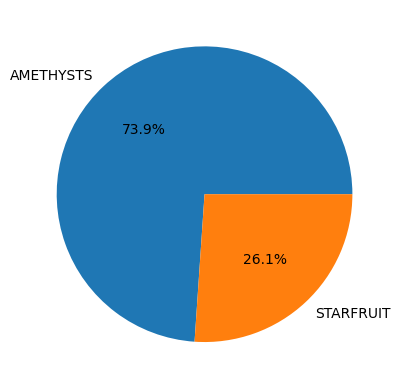

In [28]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()

cleaned_weights = ef.clean_weights()

fig, ax = plt.subplots()
ax.pie(ef.weights, labels=assets, autopct='%1.1f%%')
plt.savefig(f"{Config.CHARTS_DIR}/R1_Optimum_weights.jpg")

Text(0.5, 1.0, 'Equal Weights Portfolio')

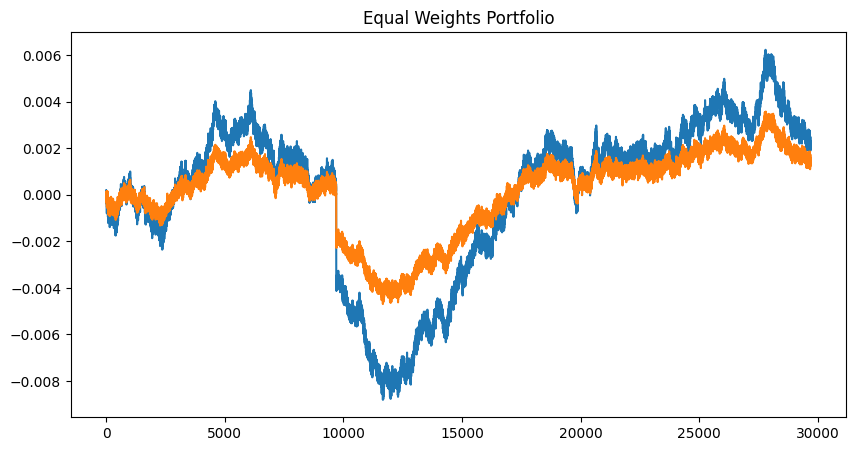

In [32]:
min_volatility_Prets = np.cumsum(returns["AMETHYSTS"]*0.739) + np.cumsum(returns["STARFRUIT"]*0.261)
base_rets = np.cumsum(returns["AMETHYSTS"]*0.5) + np.cumsum(returns["STARFRUIT"]*0.5)
fig = plt.figure(figsize=(10,5))
plt.plot(base_rets)
plt.plot(min_volatility_Prets)
plt.title("Equal Weights Portfolio")

In [33]:
import json

sf = starfruit.copy()

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

cutoff = int(len(sf)*0.80)
train_data = sf[main_feats][:cutoff]
test_data = sf[main_feats][cutoff:]

X = sf[["OBI", "ask_price_3", "bid_price_3"]]
y = sf["mid_price"]
y = y.astype(str)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo RidgeClassifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_scaled, y_train)

# Evaluar el modelo
train_accuracy = ridge_classifier.score(X_train_scaled, y_train)
test_accuracy = ridge_classifier.score(X_test_scaled, y_test)

print(train_accuracy, test_accuracy)

print(ridge_classifier.coef_)

model.fit(X_train, y_train)

0.023695286195286196 0.021043771043771045
[[ 4.41497813e-04 -3.81544852e-04  1.91261902e-05]
 [-4.92953848e-06 -1.50309609e-04  5.62615867e-06]
 [ 1.17224567e-03 -7.72768892e-04  4.02965279e-05]
 [-1.24483908e-04 -6.69015874e-04  2.54482873e-05]
 [ 6.64553941e-04 -1.19736366e-03  5.00473166e-05]
 [-1.24248890e-04 -8.93295826e-04  3.42786910e-05]
 [ 4.12612582e-04 -1.28476730e-03  5.66999624e-05]
 [-3.88014764e-04 -1.35547433e-03  6.11366050e-05]
 [ 6.31360294e-04 -1.57733180e-03  7.74900652e-05]
 [-2.20121159e-04 -1.40554248e-03  6.37322934e-05]
 [ 1.28097363e-03 -3.23902069e-03  1.44029707e-04]
 [-3.78888263e-04 -2.37889788e-03  1.13817017e-04]
 [ 2.17999384e-03 -5.62278749e-03  2.48816209e-04]
 [-8.07181870e-04 -4.00757309e-03  1.76676545e-04]
 [ 1.36276467e-03 -6.32635349e-03  2.93189300e-04]
 [-1.22517922e-03 -4.07389408e-03  1.78405096e-04]
 [ 7.16731133e-04 -4.43927477e-03  2.02254965e-04]
 [-1.08843647e-03 -4.52106228e-03  2.15546036e-04]
 [ 1.26761971e-03 -5.31370837e-03  2.575

Ridge()

In [36]:
preds = ridge_classifier.predict(X_test)

c:\Users\Ramon\github\rvargas42\IMC_Prosperity2_BigWhales\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RidgeClassifier was fitted without feature names
  warnings.warn(


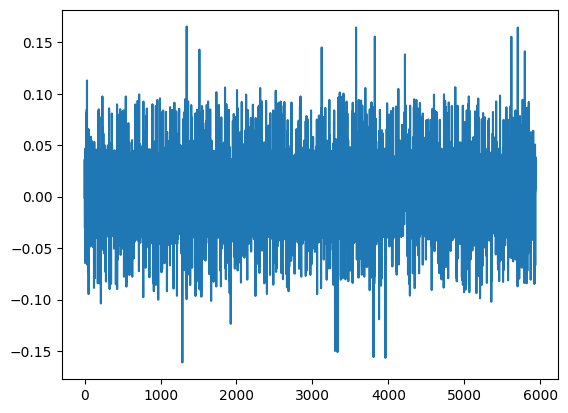

In [37]:
x_test = scaler.inverse_transform(X_test)
df = pd.DataFrame(x_test, columns=["OBI", "ask_price_3", "bid_price_3"])
plt.plot(df.OBI)

In [38]:
X=[1,2,3,4,5,6]
y=[2,4,6,8,10,12]
slope = np.polyfit(x=X, y=y, deg=1)
slope

array([2.00000000e+00, 2.73497175e-15])